## In this analysis I will try to answer 3 following questions regarding air pollution in Almaty for the period of 2017-2020:

1.     What factors can help us predict air pollution levels and thus can be possibly affecting it?

2.     How does air quality deteriorate during the colder weather and heating seasons?

3.     How did city lockdown due to COVID-19, and decreased car traffic as a result of it, affect the air quality?

## Structure:
### 1. Introduction, data extraction and exploration, feature generation
### 2. Answering the 3 questions 
    2.1 Finding the most important factors for predicting PM2.5
    2.2 Determining impact of the heating season on PM2.5 level
    2.3 Determining impact of the quarantine on PM2.5 level
### 3. Conclusions

### A blog post based on the analysis is here https://www.linkedin.com/pulse/analysis-factors-including-lock-down-due-covid-19-affect-utyubayev

# 1.  Introduction, data extraction and exploration, feature generation

### In this notebook I try to predict values of air pollution by PM2.5 particles (more on that https://blissair.com/what-is-pm-2-5.htm) in Almaty city, Kazakhstan during 2017-2020 period of time using weather, calendar dates and the fact that there was a quarantine due to COVID-19 pandemic in March-April 2020, which led to a significant reduction of the traffic. 
### I was particularly motivated to see if the quarantine and hence car traffic would turn out to be a significant factor that affected air pollution, however, the analysis showed that it was not a major factor and that air temperature, precipitation, wind and heating season were more important factors.

## Load and explore weather data

### Source - https://rp5.ru/Архив_погоды_в_Алматы_(аэропорт)

In [58]:
#importing libararies
import pandas as pd
import numpy as np

#loading weather data into a dataframe
dataAll = pd.read_excel('almaty_weather_201701_to_202006.xls', skiprows=range(6))
dataAll.head()

,Местное время в Алматы (аэропорт),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,21.06.2020 15:00,26.2,699.7,755.5,-0.9,25.0,"Ветер, дующий с востоко-северо-востока",4.0,NaN,NaN,...,"Высококучевые просвечивающие, расположенные на...","Перистых, перисто-кучевых или перисто-слоистых...",10,4.8,NaN,NaN,NaN,NaN,NaN,NaN
1,21.06.2020 12:00,24.5,700.6,756.9,-1.3,23.0,"Ветер, дующий с северо-востока",4.0,NaN,NaN,...,NaN,NaN,10,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21.06.2020 09:00,20.6,701.9,759.0,-0.5,29.0,"Ветер, дующий с северо-северо-востока",2.0,NaN,NaN,...,NaN,NaN,10,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21.06.2020 06:00,9.8,702.4,761.8,-0.4,62.0,"Ветер, дующий с востока",1.0,NaN,NaN,...,NaN,NaN,10,2.8,NaN,NaN,NaN,NaN,NaN,NaN
4,21.06.2020 03:00,10.2,702.8,762.2,-1.1,61.0,"Ветер, дующий с юго-востока",2.0,NaN,NaN,...,"Высококучевые просвечивающие, расположенные на...","Перистых, перисто-кучевых или перисто-слоистых...",10,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# select needed columns
data = dataAll[['Местное время в Алматы (аэропорт)', 'T', 'Ff', 'RRR', 'DD']].copy()
data.head()

,Местное время в Алматы (аэропорт),T,Ff,RRR,DD
0,21.06.2020 15:00,26.2,4.0,NaN,"Ветер, дующий с востоко-северо-востока"
1,21.06.2020 12:00,24.5,4.0,NaN,"Ветер, дующий с северо-востока"
2,21.06.2020 09:00,20.6,2.0,NaN,"Ветер, дующий с северо-северо-востока"
3,21.06.2020 06:00,9.8,1.0,NaN,"Ветер, дующий с востока"
4,21.06.2020 03:00,10.2,2.0,NaN,"Ветер, дующий с юго-востока"


In [60]:
print(data.isna().sum())

Местное время в Алматы (аэропорт)       0
T                                       5
Ff                                    239
RRR                                  7004
DD                                    243
dtype: int64


### Rename columns

In [61]:
# rename columns
data.rename(columns={"Местное время в Алматы (аэропорт)": "DateTime", "T": "Temperature_C", 'Ff': 'Wind Speed', 
                     'RRR':'Precipitation_mm', "DD": "Wind direction"}, inplace = True)
data.head()

,DateTime,Temperature_C,Wind Speed,Precipitation_mm,Wind direction
0,21.06.2020 15:00,26.2,4.0,NaN,"Ветер, дующий с востоко-северо-востока"
1,21.06.2020 12:00,24.5,4.0,NaN,"Ветер, дующий с северо-востока"
2,21.06.2020 09:00,20.6,2.0,NaN,"Ветер, дующий с северо-северо-востока"
3,21.06.2020 06:00,9.8,1.0,NaN,"Ветер, дующий с востока"
4,21.06.2020 03:00,10.2,2.0,NaN,"Ветер, дующий с юго-востока"


In [62]:
#check whether date was loaded correctly
data.dtypes

DateTime             object
Temperature_C       float64
Wind Speed          float64
Precipitation_mm     object
Wind direction       object
dtype: object

### Convert Precipitation_mm data where it's a string instead of a number 

In [63]:
# some days have 'No prectipitation', let's assign zero insted
data['Precipitation_mm'] = data['Precipitation_mm'].apply(lambda x: 0 if x == 'Осадков нет' else x)

# assign nan where we have unclear data - 'Some precipitation'
data['Precipitation_mm'] = data['Precipitation_mm'].apply(lambda x: float('nan') if x == 'Следы осадков' else x)

data.astype({'Precipitation_mm': 'float64'}).dtypes

DateTime             object
Temperature_C       float64
Wind Speed          float64
Precipitation_mm    float64
Wind direction       object
dtype: object

### Add date columns

In [64]:
# get datetime in the correct format
data['DateTime'] = pd.to_datetime(data['DateTime'], format = '%d.%m.%Y %H:%M')
data.head()

,DateTime,Temperature_C,Wind Speed,Precipitation_mm,Wind direction
0,2020-06-21 15:00:00,26.2,4.0,NaN,"Ветер, дующий с востоко-северо-востока"
1,2020-06-21 12:00:00,24.5,4.0,NaN,"Ветер, дующий с северо-востока"
2,2020-06-21 09:00:00,20.6,2.0,NaN,"Ветер, дующий с северо-северо-востока"
3,2020-06-21 06:00:00,9.8,1.0,NaN,"Ветер, дующий с востока"
4,2020-06-21 03:00:00,10.2,2.0,NaN,"Ветер, дующий с юго-востока"


In [65]:
# extract date
data['Date'] = data['DateTime'].dt.date
data.head()

,DateTime,Temperature_C,Wind Speed,Precipitation_mm,Wind direction,Date
0,2020-06-21 15:00:00,26.2,4.0,NaN,"Ветер, дующий с востоко-северо-востока",2020-06-21
1,2020-06-21 12:00:00,24.5,4.0,NaN,"Ветер, дующий с северо-востока",2020-06-21
2,2020-06-21 09:00:00,20.6,2.0,NaN,"Ветер, дующий с северо-северо-востока",2020-06-21
3,2020-06-21 06:00:00,9.8,1.0,NaN,"Ветер, дующий с востока",2020-06-21
4,2020-06-21 03:00:00,10.2,2.0,NaN,"Ветер, дующий с юго-востока",2020-06-21


### Encode wind direction

In [66]:
# get all possible values for wind direction
wind_directions = data['Wind direction'].unique()
print(wind_directions)

['Ветер, дующий с востоко-северо-востока' 'Ветер, дующий с северо-востока'
 'Ветер, дующий с северо-северо-востока' 'Ветер, дующий с востока'
 'Ветер, дующий с юго-востока' 'Ветер, дующий с юго-юго-востока'
 'Ветер, дующий с западо-северо-запада'
 'Ветер, дующий с северо-северо-запада'
 'Ветер, дующий с западо-юго-запада' 'Ветер, дующий с юга'
 'Ветер, дующий с юго-запада' 'Ветер, дующий с запада'
 'Ветер, дующий с юго-юго-запада' 'Ветер, дующий с востоко-юго-востока'
 'Ветер, дующий с северо-запада' 'Штиль, безветрие'
 'Ветер, дующий с севера' 'Переменное направление' nan]


In [67]:
# assign '' to nan to have all strings in Wind direction to distinguish empty strings from those with values 
data['Wind direction'] = data['Wind direction'].fillna('')
# get all possible values for wind direction
wind_directions = data['Wind direction'].unique()
print(wind_directions)

['Ветер, дующий с востоко-северо-востока' 'Ветер, дующий с северо-востока'
 'Ветер, дующий с северо-северо-востока' 'Ветер, дующий с востока'
 'Ветер, дующий с юго-востока' 'Ветер, дующий с юго-юго-востока'
 'Ветер, дующий с западо-северо-запада'
 'Ветер, дующий с северо-северо-запада'
 'Ветер, дующий с западо-юго-запада' 'Ветер, дующий с юга'
 'Ветер, дующий с юго-запада' 'Ветер, дующий с запада'
 'Ветер, дующий с юго-юго-запада' 'Ветер, дующий с востоко-юго-востока'
 'Ветер, дующий с северо-запада' 'Штиль, безветрие'
 'Ветер, дующий с севера' 'Переменное направление' '']


In [68]:
# here we encode wind direction using 4 variables - each will show if the wind was blowing from particular direction
data['is_east_wind'] = data['Wind direction'].apply(lambda x: 1 if ('востоко' in x or 'востока' in x) else 0)
data['is_south_wind'] = data['Wind direction'].apply(lambda x: 1 if ('юго' in x or 'юга' in x) else 0)
data['is_west_wind'] = data['Wind direction'].apply(lambda x: 1 if ('западо' in x or 'запада' in x) else 0)
data['is_north_wind'] = data['Wind direction'].apply(lambda x: 1 if ('северо' in x or 'севера' in x) else 0)


### Before deleting null data related to rain and wind, let's delete days empty temperature and store temperature in Celcius in a separate dataframe to later merge with air quality data

In [69]:
# select not null temp values as null temperature data will not be usefull
dataTempC = data[data['Temperature_C'].notna()].copy()
dataTempC = dataTempC[['Date', 'Temperature_C']]

# group temperature data by day
dataTempC = dataTempC.groupby('Date').agg({
    'Temperature_C':'mean',
}).copy()
dataTempC.reset_index(inplace = True)
dataTempC['Date'] = pd.to_datetime(dataTempC['Date'], format = '%Y-%m-%d')
dataTempC.head()

,Date,Temperature_C
0,2017-01-01,-1.4625
1,2017-01-02,-2.0000
2,2017-01-03,0.4625
3,2017-01-04,-2.5500
4,2017-01-05,-1.6875


### Deal with the empty data - drop nulls for wind, rain before aggregating

In [70]:
# fill null precipitation data with zeroes as those were empty cells meaning there was no precipitation
data['Precipitation_mm'].fillna(0, inplace=True)
data.head()

,DateTime,Temperature_C,Wind Speed,Precipitation_mm,Wind direction,Date,is_east_wind,is_south_wind,is_west_wind,is_north_wind
0,2020-06-21 15:00:00,26.2,4.0,0.0,"Ветер, дующий с востоко-северо-востока",2020-06-21,1,0,0,1
1,2020-06-21 12:00:00,24.5,4.0,0.0,"Ветер, дующий с северо-востока",2020-06-21,1,0,0,1
2,2020-06-21 09:00:00,20.6,2.0,0.0,"Ветер, дующий с северо-северо-востока",2020-06-21,1,0,0,1
3,2020-06-21 06:00:00,9.8,1.0,0.0,"Ветер, дующий с востока",2020-06-21,1,0,0,0
4,2020-06-21 03:00:00,10.2,2.0,0.0,"Ветер, дующий с юго-востока",2020-06-21,1,1,0,0


In [71]:
# drop other null data - we will not be able to use them for prediction as we don't know for sure if it was zero
data.dropna(inplace=True)

# count null values to make sure there are zero of them
print(data.isna().sum())

DateTime            0
Temperature_C       0
Wind Speed          0
Precipitation_mm    0
Wind direction      0
Date                0
is_east_wind        0
is_south_wind       0
is_west_wind        0
is_north_wind       0
dtype: int64


### Aggregate data

In [72]:
# group data by day
# the wind directions are added up to show how many times in the day the direction was that one
data_agg = data.groupby('Date').agg({
    'Temperature_C':'mean',
    'Wind Speed':'max',
    'Precipitation_mm':'sum',
    'is_east_wind':'sum',
    'is_south_wind':'sum',
    'is_west_wind':'sum',
    'is_north_wind':'sum'
}).copy()
data_agg.reset_index(inplace = True)
data_agg['Date'] = pd.to_datetime(data_agg['Date'], format = '%Y-%m-%d')
data_agg.head()

,Date,Temperature_C,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind
0,2017-01-01,-1.4625,3.0,0.0,5,4,0,3
1,2017-01-02,-2.0000,3.0,0.0,0,7,3,0
2,2017-01-03,0.4625,10.0,2.0,3,8,2,0
3,2017-01-04,-2.5500,3.0,2.0,3,8,4,0
4,2017-01-05,-1.6875,6.0,0.0,1,7,7,1


In [73]:
# pick the most prevalent wind direction (i.e. the average > 0.5 = round to the nearest integer)
#data_agg['is_east_wind'] = round(data_agg['is_east_wind_in'],0) 
#data_agg['is_south_wind'] = round(data_agg['is_south_wind_in'],0) 
#data_agg.head()

In [74]:
# drop temporary columns
#data_agg.drop(columns=['is_east_wind_in', 'is_south_wind_in'], inplace=True)

In [75]:
data_agg.dtypes

Date                datetime64[ns]
Temperature_C              float64
Wind Speed                 float64
Precipitation_mm           float64
is_east_wind                 int64
is_south_wind                int64
is_west_wind                 int64
is_north_wind                int64
dtype: object

In [76]:
# add temperatures in Kelvin to avoid dealing with negative and 0 values
data_agg['avrg_temp_Kelvin'] = data_agg['Temperature_C'] + 273.15
data_agg.drop(['Temperature_C'], axis = 1, inplace = True)
data_agg.head()

,Date,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin
0,2017-01-01,3.0,0.0,5,4,0,3,271.6875
1,2017-01-02,3.0,0.0,0,7,3,0,271.1500
2,2017-01-03,10.0,2.0,3,8,2,0,273.6125
3,2017-01-04,3.0,2.0,3,8,4,0,270.6000
4,2017-01-05,6.0,0.0,1,7,7,1,271.4625


In [77]:
#check numerical variables' stats
data_agg.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin
count,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,4.024954,2.335952,2.749538,3.281885,2.332717,2.519409,284.277242
std,1.711993,6.674058,1.721369,1.673935,1.796343,1.527452,11.114327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,258.110000
25%,3.000000,0.000000,1.000000,2.000000,1.000000,1.000000,274.296875
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,286.243750
75%,5.000000,0.700000,4.000000,4.000000,3.000000,3.000000,293.650000
max,16.000000,59.000000,8.000000,8.000000,8.000000,8.000000,303.312500


In [78]:
# adding weekday for later analysis
data_agg['weekday'] = data_agg['Date'].dt.weekday
data_agg['is_weekend'] = data_agg['weekday'].apply(lambda x: 1 if (x >= 5) else 0)
data_agg.drop(['weekday'], axis = 1,inplace = True)

In [79]:
data_agg.head()

,Date,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend
0,2017-01-01,3.0,0.0,5,4,0,3,271.6875,1
1,2017-01-02,3.0,0.0,0,7,3,0,271.1500,0
2,2017-01-03,10.0,2.0,3,8,2,0,273.6125,0
3,2017-01-04,3.0,2.0,3,8,4,0,270.6000,0
4,2017-01-05,6.0,0.0,1,7,7,1,271.4625,0


In [80]:
# add 'is_quarantine' variable which is true for a strict city lock down
import datetime
quarantine_start = datetime.datetime(2020, 3, 19)
quarantine_end = datetime.datetime(2020, 5, 11)
data_agg['is_quarantine'] = data_agg['Date'].apply(lambda x: 1 if (x >= quarantine_start and x <= quarantine_end) else 0)

## Load and explore air quality data

### Source https://www.airkaz.org

In [81]:
#loading air qulaity data into a dataframe
dataAir_temp = pd.read_excel('daily_almaty_14apr20.xls', sheet_name='data')
dataAir_temp = dataAir_temp[['Row Labels', 'Grand Total']]
dataAir_temp.head()

,Row Labels,Grand Total
0,22-Mar,91.982979
1,23-Mar,84.649269
2,24-Mar,126.039535
3,25-Mar,63.183913
4,26-Mar,38.572597


In [82]:
dataAir_temp.describe()

,Grand Total
count,1115.000000
mean,51.197883
std,41.409219
min,7.769390
25%,21.309051
50%,34.677905
75%,70.402415
max,259.568449


In [83]:
dataAir_temp.dtypes

Row Labels      object
Grand Total    float64
dtype: object

In [84]:
# check if any null values
print(dataAir_temp['Grand Total'].isna().sum())

0


In [85]:
dataAir_temp.rename(columns={'Grand Total':'PM2.5', 'Row Labels': 'Day'}, inplace = True)

In [86]:
# check how date is stored
print(dataAir_temp['Day'][0] == '22-Mar')

True


In [87]:
# no year in the excel source, so will need to iterate and fill out Year column 
startYear = 2017
year = startYear
years = []
for index, row in dataAir_temp.iterrows():
    if row['Day'] == '1-Jan':
        year += 1
    years.append(year)
print(year)

2020


In [88]:
dataAir_temp['Year'] = years
print(dataAir_temp['Year'])

0       2017
1       2017
2       2017
3       2017
4       2017
        ... 
1110    2020
1111    2020
1112    2020
1113    2020
1114    2020
Name: Year, Length: 1115, dtype: int64


In [89]:
# try to transform initial bad date column to a normal date leads to year being set to 1900 by default
dataAir_temp['Day_new'] = pd.to_datetime(dataAir_temp['Day'], format='%d-%b', errors = 'coerce')
dataAir_temp.head()

,Day,PM2.5,Year,Day_new
0,22-Mar,91.982979,2017,1900-03-22
1,23-Mar,84.649269,2017,1900-03-23
2,24-Mar,126.039535,2017,1900-03-24
3,25-Mar,63.183913,2017,1900-03-25
4,26-Mar,38.572597,2017,1900-03-26


In [90]:
# replace default 1900 year by the one we manually set above bu iterating
dataAir_temp['Date'] = dataAir_temp.apply(lambda x: x['Day_new'].replace(year = x['Year']), axis=1)
dataAir = dataAir_temp[['Date', 'PM2.5']]
dataAir.head()

,Date,PM2.5
0,2017-03-22,91.982979
1,2017-03-23,84.649269
2,2017-03-24,126.039535
3,2017-03-25,63.183913
4,2017-03-26,38.572597


In [91]:
print(dataAir['Date'])

0      2017-03-22
1      2017-03-23
2      2017-03-24
3      2017-03-25
4      2017-03-26
          ...    
1110   2020-04-10
1111   2020-04-11
1112   2020-04-12
1113   2020-04-13
1114   2020-04-14
Name: Date, Length: 1115, dtype: datetime64[ns]


In [92]:
print(dataAir['PM2.5'])

0        91.982979
1        84.649269
2       126.039535
3        63.183913
4        38.572597
           ...    
1110     30.592491
1111     55.873913
1112     39.518228
1113     26.392828
1114     22.953115
Name: PM2.5, Length: 1115, dtype: float64


### Let's add heating season variable

In [93]:
# add 'is_heating' variable to air datea before merging with weather data. 
# The variable is "Yes" when there is heating season in Almaty and central heating is on and "No" otherwise
import datetime

heating_end_2017 = datetime.datetime(2017, 4, 11)
heating_start_2018 = datetime.datetime(2017, 10, 15)

heating_end_2018 = datetime.datetime(2018, 4, 12)
heating_start_2019 = datetime.datetime(2018, 10, 15)

heating_end_2019 = datetime.datetime(2019, 4, 4)
heating_start_2020 = datetime.datetime(2019, 10, 15)

heating_end_2020 = datetime.datetime(2020, 4, 22)

dataAir['is_heating_season'] = dataAir['Date'].apply(lambda x: 'Non-heating season' if ((x > heating_end_2017 and x < heating_start_2018) or (x > heating_end_2018 and x < heating_start_2019) or (x > heating_end_2019 and x < heating_start_2020) or x > heating_end_2020)
                                    else 'Heating season')

# also add numerical variable 'is_heating' for calculations
# add a categorical variable 'is_heating_season' with values of 'Yes' and 'No' for better visuals
dataAir['is_heating'] = dataAir['is_heating_season'].apply(lambda heat: 1 if heat=='Heating season' else 0)

dataAir.head()

/Users/Utyubayev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/Utyubayev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,PM2.5,is_heating_season,is_heating
0,2017-03-22,91.982979,Heating season,1
1,2017-03-23,84.649269,Heating season,1
2,2017-03-24,126.039535,Heating season,1
3,2017-03-25,63.183913,Heating season,1
4,2017-03-26,38.572597,Heating season,1


In [94]:
dataAir = dataAir[['Date', 'PM2.5', 'is_heating_season', 'is_heating']]

### Merging air quality data and weather

In [95]:
dataMerged = pd.merge(data_agg, dataAir, on='Date')
dataMerged.head()

,Date,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,PM2.5,is_heating_season,is_heating
0,2017-03-22,3.0,0.0,4,0,4,5,275.650000,0,0,91.982979,Heating season,1
1,2017-03-23,3.0,0.0,3,5,3,0,279.712500,0,0,84.649269,Heating season,1
2,2017-03-24,8.0,0.0,4,2,3,6,283.150000,0,0,126.039535,Heating season,1
3,2017-03-25,7.0,0.0,4,2,2,5,285.850000,1,0,63.183913,Heating season,1
4,2017-03-26,8.0,0.0,0,4,7,2,282.278571,1,0,38.572597,Heating season,1


In [96]:
dataMerged.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,PM2.5,is_heating
count,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000
mean,4.020496,2.366127,2.725998,3.237325,2.244876,2.444444,284.986791,0.286947,0.028047,45.048085,0.417476
std,1.702054,6.624343,1.712741,1.633805,1.709273,1.449245,10.880656,0.452581,0.165198,35.873049,0.493409
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,258.110000,0.000000,0.000000,7.769390,0.000000
25%,3.000000,0.000000,1.000000,2.000000,1.000000,1.000000,275.612500,0.000000,0.000000,20.255270,0.000000
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,286.670000,0.000000,0.000000,30.033238,0.000000
75%,5.000000,0.700000,4.000000,4.000000,3.000000,3.000000,293.970000,1.000000,0.000000,60.442089,1.000000
max,12.000000,59.000000,8.000000,8.000000,8.000000,8.000000,303.312500,1.000000,1.000000,248.982866,1.000000


### Also merge air quality data with a bigger dataset with temperatures only to plot a graph

In [97]:
dataMergedTemp = pd.merge(dataTempC, dataAir, on='Date')
dataMergedTemp.head()

,Date,Temperature_C,PM2.5,is_heating_season,is_heating
0,2017-03-22,2.500000,91.982979,Heating season,1
1,2017-03-23,6.562500,84.649269,Heating season,1
2,2017-03-24,10.000000,126.039535,Heating season,1
3,2017-03-25,12.700000,63.183913,Heating season,1
4,2017-03-26,9.128571,38.572597,Heating season,1


In [98]:
#from datetime import datetime
#dataMerged = dataMerged[dataMerged['Date'] >= datetime.strptime('2019-01-01','%Y-%m-%d')]

## Is there a problem at all - compare Almaty air quality with that of NYC in 2019

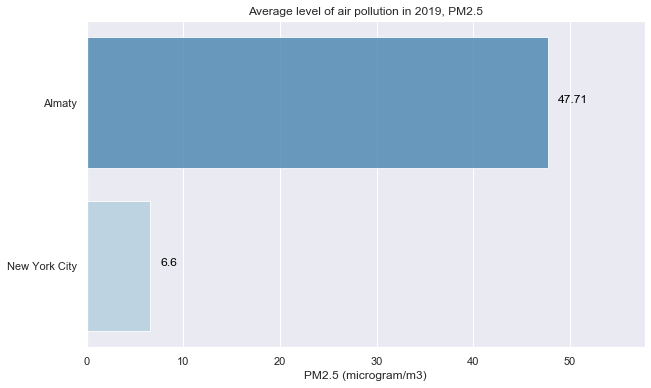

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# source - https://www.americashealthrankings.org/explore/annual/measure/air/state/NY
NYC_PM25_average_2019 = 6.6
AlmatyPM25_average_2019 = dataAir['PM2.5'][dataAir['Date'].dt.year == 2019].mean()

fig, ax = plt.subplots()

# set size and style
fig.set_size_inches(10,6)

values = [AlmatyPM25_average_2019, NYC_PM25_average_2019]
labels = ['Almaty', 'New York City']

sns.set()
sns.set_style('darkgrid')
ax = sns.barplot(x=values, y=labels, alpha=0.8, palette='Blues_r')
ax.set_xlabel('PM2.5 (microgram/m3)')

# show values
for index, value in enumerate(values):
    ax.text(value+1, index, str(round(value,2)), color='black')

ax.set(xlim=(0,max(values)+10))    
plt.title('Average level of air pollution in 2019, PM2.5')
plt.show()
#ax.figure.savefig('images/new_york_almaty.png', bbox_inches="tight")

#### Almaty has much worse air pollution in terms of PM2.5 than NYC

# 2.1 Finding the most factors for predicting PM2.5

### Create X and Y

In [99]:
import copy 

# for the base model test we will need previous value of PM2.5 - will drop it afterwards
dataMerged['Prev_PM'] = dataMerged['PM2.5'].shift(1)
# drop the first date as it will have empty Prev_PM value
dataMerged.dropna(inplace=True)

X = copy.deepcopy(dataMerged)

# drop the answer (PM2.5) and other irrelevant features
X.drop(['PM2.5','Date', 'is_heating_season'], axis=1, inplace = True)

In [100]:
y = copy.deepcopy(dataMerged['PM2.5'])

### Split X and Y into train, validate, test

In [101]:
#train-validate-test split
from sklearn.model_selection import train_test_split

# first get training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
# then split test data into 2 halves: validate and final test
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=3)

### Check to see if the split was random enough

In [102]:
# check to see if the split was random = proportions of is_heating days and is_quarantine days are similar to those in the initial X 
X_train.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating,Prev_PM
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,3.978378,2.357658,2.675676,3.275676,2.218018,2.381982,284.955286,0.284685,0.027027,0.421622,46.162073
std,1.696110,6.238647,1.684299,1.604833,1.748966,1.441407,10.768719,0.451671,0.162308,0.494264,37.082202
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.512500,0.000000,0.000000,0.000000,7.769390
25%,3.000000,0.000000,1.000000,2.000000,1.000000,1.000000,275.437500,0.000000,0.000000,0.000000,20.276155
50%,4.000000,0.000000,2.000000,3.000000,2.000000,2.000000,286.566667,0.000000,0.000000,0.000000,30.192359
75%,5.000000,0.700000,4.000000,4.000000,3.000000,3.000000,293.837500,1.000000,0.000000,1.000000,63.047447
max,12.000000,52.000000,8.000000,8.000000,8.000000,8.000000,303.283333,1.000000,1.000000,1.000000,248.982866


In [103]:
X_validate.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating,Prev_PM
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,4.075676,2.568108,2.767568,3.124324,2.108108,2.459459,284.828917,0.291892,0.027027,0.427027,42.757092
std,1.782982,7.361106,1.701990,1.754095,1.496078,1.463219,11.092780,0.455867,0.162602,0.495989,33.511327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,258.110000,0.000000,0.000000,0.000000,9.441185
25%,3.000000,0.000000,1.000000,2.000000,1.000000,2.000000,275.862500,0.000000,0.000000,0.000000,20.021117
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,286.037500,0.000000,0.000000,0.000000,28.147104
75%,5.000000,1.000000,4.000000,4.000000,3.000000,3.000000,293.912500,1.000000,0.000000,1.000000,55.136005
max,12.000000,59.000000,7.000000,8.000000,7.000000,7.000000,303.312500,1.000000,1.000000,1.000000,178.389473


In [104]:
X_test.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating,Prev_PM
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,4.096774,2.203226,2.827957,3.252688,2.451613,2.602151,285.288021,0.290323,0.032258,0.392473,44.121555
std,1.644414,7.007432,1.810621,1.585617,1.776825,1.445513,11.060704,0.455136,0.177162,0.489619,34.555545
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.850000,0.000000,0.000000,0.000000,8.681383
25%,3.000000,0.000000,1.000000,2.000000,1.000000,2.000000,276.642500,0.000000,0.000000,0.000000,20.172062
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,287.428750,0.000000,0.000000,0.000000,29.582500
75%,5.000000,0.375000,4.000000,4.000000,4.000000,3.750000,294.375000,1.000000,0.000000,1.000000,58.819996
max,11.000000,57.000000,7.000000,8.000000,7.000000,8.000000,302.625000,1.000000,1.000000,1.000000,184.068610


### We will be using mean absolute error (MAE) to measure the model accuracy, so the less on average our predictions differ from the actual PM2.5 data the better is a model 

In [105]:
# define functions to return MAE and MAPE (mean absolute percent error, just in case we will use it)

# return_mae function returns mean absolute error, rounded by 2 digits, and takes in two iterables - the predictions and actual data
def return_mae(prediction, actual):
    '''
        Return_mae function returns mean absolute error, 
        rounded by 2 digits, and takes in two input iterables - 
        the predictions and actual data
    '''
    import numpy as np
    errors = abs(prediction - actual)
    return round(np.mean(errors), 2)
    
# return_mape function returns mean absolute percent error, rounded by 2 digits, and takes in two iterables - the predictions and actual data
def return_mape(prediction, actual):
    '''
        Return_mape function returns mean absolute percent error, 
        rounded by 2 digits, and takes in two input iterables - 
        the predictions and actual data
    '''
    import numpy as np
    errors = 100 * abs( (prediction - actual) / actual )
    return round(np.mean(errors), 2)

## Base model

### First, let's create some base model to compare with other models. The base model will simply predict today's PM2.5 value to be the same as yesterday's

In [106]:
# adding previous PM2.5 reading
X_temp = X_test.copy()
y_temp = y_test.copy()

X_temp.head()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating,Prev_PM
556,3.0,0.0,3,2,0,3,281.87,0,0,0,37.387504
104,4.0,0.0,4,4,1,3,301.95,1,0,0,20.095694
554,4.0,57.0,1,3,5,1,283.15,1,0,0,31.035622
577,4.0,0.0,3,1,1,3,287.47,0,0,0,31.236348
636,3.0,0.0,2,4,3,0,299.19,0,0,0,13.704709


In [107]:
# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(X_temp['Prev_PM'], y_temp) )

base_mae = return_mae(X_temp['Prev_PM'], y_temp)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:',  base_mae)


Percent Absolute Error: 28.11
Mean Absolute Error: 12.06


### As we see, by just using previous day value as a prediction we get a mean absolute error (MAE) of 12.06 for PM2.5

## Now train 3 models (Linear Regression, Random Forest and XGBoost) and check the accuracy (MAE) on validate data to select the best model

### Drop the Prev_PM variable from all the Xs

In [108]:
# drop previous PM2.5 values now
X.drop(['Prev_PM'], axis=1, inplace = True)
X_test.drop(['Prev_PM'], axis=1, inplace = True)
X_validate.drop(['Prev_PM'], axis=1, inplace = True)
X_train.drop(['Prev_PM'], axis=1, inplace = True)

/Users/Utyubayev/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [109]:
# check to see if the split was random = proportions of is_heating days and is_quarantine days are similar to those in the initial X 
X_train.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,3.978378,2.357658,2.675676,3.275676,2.218018,2.381982,284.955286,0.284685,0.027027,0.421622
std,1.696110,6.238647,1.684299,1.604833,1.748966,1.441407,10.768719,0.451671,0.162308,0.494264
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.512500,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.000000,2.000000,1.000000,1.000000,275.437500,0.000000,0.000000,0.000000
50%,4.000000,0.000000,2.000000,3.000000,2.000000,2.000000,286.566667,0.000000,0.000000,0.000000
75%,5.000000,0.700000,4.000000,4.000000,3.000000,3.000000,293.837500,1.000000,0.000000,1.000000
max,12.000000,52.000000,8.000000,8.000000,8.000000,8.000000,303.283333,1.000000,1.000000,1.000000


In [110]:
X_validate.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,4.075676,2.568108,2.767568,3.124324,2.108108,2.459459,284.828917,0.291892,0.027027,0.427027
std,1.782982,7.361106,1.701990,1.754095,1.496078,1.463219,11.092780,0.455867,0.162602,0.495989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,258.110000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.000000,2.000000,1.000000,2.000000,275.862500,0.000000,0.000000,0.000000
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,286.037500,0.000000,0.000000,0.000000
75%,5.000000,1.000000,4.000000,4.000000,3.000000,3.000000,293.912500,1.000000,0.000000,1.000000
max,12.000000,59.000000,7.000000,8.000000,7.000000,7.000000,303.312500,1.000000,1.000000,1.000000


In [111]:
X_test.describe()

,Wind Speed,Precipitation_mm,is_east_wind,is_south_wind,is_west_wind,is_north_wind,avrg_temp_Kelvin,is_weekend,is_quarantine,is_heating
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,4.096774,2.203226,2.827957,3.252688,2.451613,2.602151,285.288021,0.290323,0.032258,0.392473
std,1.644414,7.007432,1.810621,1.585617,1.776825,1.445513,11.060704,0.455136,0.177162,0.489619
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.850000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.000000,2.000000,1.000000,2.000000,276.642500,0.000000,0.000000,0.000000
50%,4.000000,0.000000,3.000000,3.000000,2.000000,2.000000,287.428750,0.000000,0.000000,0.000000
75%,5.000000,0.375000,4.000000,4.000000,4.000000,3.750000,294.375000,1.000000,0.000000,1.000000
max,11.000000,57.000000,7.000000,8.000000,7.000000,8.000000,302.625000,1.000000,1.000000,1.000000


### Let's see how features are correlated linearly with PM2.5

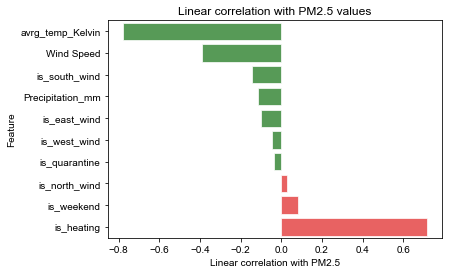

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# set size and style
#fig.set_size_inches(12.5, 7)

corrMatrix = X.corrwith(y).sort_values()

sns.set()

ax = sns.barplot(y=corrMatrix.index, x=corrMatrix.values, palette=['red' if x > 0 else 'green' for x in corrMatrix.values],
                 alpha=0.7)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Linear correlation with PM2.5 values')
ax.set_xlabel('Linear correlation with PM2.5')
ax.set_ylabel('Feature')

plt.show()
#ax.figure.savefig('images/Corr.png', bbox_inches="tight")

#### Most of the features show negative linear correlation with PM2.5, but heating season, weekend and north wind show positive linear correlation 

## Linear Regression

In [113]:
from sklearn.preprocessing import MinMaxScaler

# to change values in the futures
X_train_copy = X_train.copy()
X_validate_copy = X_validate.copy()

scaler = MinMaxScaler()

numeric_features = ['Wind Speed', 'Precipitation_mm', 'avrg_temp_Kelvin', 'is_south_wind', 'is_north_wind', 'is_west_wind', 'is_east_wind']

X_train_copy[numeric_features] = scaler.fit_transform(X_train_copy[numeric_features])

X_validate_copy[numeric_features] = scaler.transform(X_validate_copy[numeric_features])

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(X_train_copy, y_train)
print('The coefficients are', dict(zip(X_train.columns,lin_reg.coef_)))

predictions_lin = lin_reg.predict(X_validate_copy)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions_lin, y_validate) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions_lin, y_validate) )

The coefficients are {'Wind Speed': -29.05885970304287, 'Precipitation_mm': -54.03730511499051, 'is_east_wind': -10.348971020181443, 'is_south_wind': 6.4560253732172335, 'is_west_wind': -21.74399884212665, 'is_north_wind': -19.70409096454816, 'avrg_temp_Kelvin': -87.03578680387486, 'is_weekend': 5.066717684588622, 'is_quarantine': -13.625220451147726, 'is_heating': 17.769078525053516}
Percent Absolute Error: 44.28
Mean Absolute Error: 14.03


In [114]:
# check coefficient significance
import statsmodels.api as sm

X2 = sm.add_constant(X_train_copy)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     156.7
Date:                Mon, 17 Aug 2020   Prob (F-statistic):          4.50e-153
Time:                        00:53:47   Log-Likelihood:                -2389.5
No. Observations:                 555   AIC:                             4801.
Df Residuals:                     544   BIC:                             4849.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              110.1855      5.619  

## Random Forest

In [115]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

predictions = rf.predict(X_validate)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_validate) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions, y_validate) )

Percent Absolute Error: 27.98
Mean Absolute Error: 11.2


## XG Boost

In [116]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0) 
xg_reg.fit(X_train, y_train)

predictions = xg_reg.predict(X_validate)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_validate) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions, y_validate) )

Percent Absolute Error: 25.65
Mean Absolute Error: 10.29


### The best model turns out to be XGBoost

## Select features to keep in the futher model tuning

### Check if a feature is contributing to decreasing the error by dropping the features one by one and measuring the increase of the error using whole dataset for training and error measurement

In [117]:
# a function that returns MAE for a given model
def return_model_mae(model, X, y):
    '''
        Returns MAE for a given model, 
        given input and output data - X and y
    '''
    predictions = model.predict(X)
    return return_mae(predictions, y)

In [118]:
# a function that drops features one by one and measures the impact on the error
def dropcol_importances(initial_model, return_error, X, y):
    '''
        Returns a dataframe with differences in the error for each feature in 'X'
        by dropping each feature in 'X' by turn.
        The error is calculated by using function 'return_function' input parameter
        on 'y' input and predcitions 'initial_model' when given 'X'
    '''
    import sklearn.base
    model = sklearn.base.clone(initial_model)
    model.fit(X, y)
    baseline_error = return_error(model, X, y)
    imp = []
    for col in X_train.columns:
        X_train_new = X.drop(col, axis=1)
        model.fit(X_train_new, y)
        
        new_error = return_error(model, X_train_new, y)
        
        imp.append(new_error-baseline_error)
    
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

In [119]:
# create a dataframe with feature importances based on error increase when a feature is dropped using whole data
importances = dropcol_importances(xg_reg, return_model_mae, X, y)

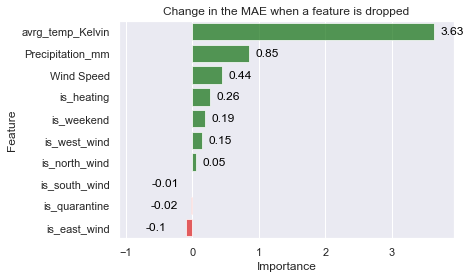

In [120]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# set size and style
#fig.set_size_inches(12.5, 7)

sns.set_style('dark')
ax = sns.barplot(y=importances.index, x=importances.Importance, palette=['green' if x > 0 else 'red' for x in importances.Importance],
                 alpha=0.7)
# show values
for index,value in enumerate(importances.Importance):
    if value >= 0:
        ax.text(value + 0.1, index, str(round(value,2)), color='black', va='center')
    else:
        ax.text(value - 0.6, index, str(round(value,2)), color='black', va='center')

# increase X axis to fit values of the bars
ax.set(xlim=(importances.Importance.min()-1,importances.Importance.max()+0.3))
    
plt.title('Change in the MAE when a feature is dropped')
plt.show()
#ax.figure.savefig('images/Feature_drop1.png', bbox_inches="tight")

## As we can see, dropping is_east_wind will result in decrease in the error (dropping is_quarantine and is_south_wind would cause very little decrease in error - so decided to keep them)

In [121]:
# dropping some values

In [122]:
X.drop(['is_east_wind'], axis=1, inplace = True)
X_test.drop(['is_east_wind'], axis=1, inplace = True)
X_validate.drop(['is_east_wind'], axis=1, inplace = True)
X_train.drop(['is_east_wind'], axis=1, inplace = True)

/Users/Utyubayev/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


"\nX.drop(['is_south_wind'], axis=1, inplace = True)\nX_test.drop(['is_south_wind'], axis=1, inplace = True)\nX_validate.drop(['is_south_wind'], axis=1, inplace = True)\nX_train.drop(['is_south_wind'], axis=1, inplace = True)\n\nX.drop(['is_north_wind'], axis=1, inplace = True)\nX_test.drop(['is_north_wind'], axis=1, inplace = True)\nX_validate.drop(['is_north_wind'], axis=1, inplace = True)\nX_train.drop(['is_north_wind'], axis=1, inplace = True)\n\nX.drop(['is_west_wind'], axis=1, inplace = True)\nX_test.drop(['is_west_wind'], axis=1, inplace = True)\nX_validate.drop(['is_west_wind'], axis=1, inplace = True)\nX_train.drop(['is_west_wind'], axis=1, inplace = True)\n"

## Hyperparameter tuning to improve XGBoost model and check the accuracy (MAE) of the best model on test set

## Let's first see performance of the default XGBoost model on test data

In [123]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0) 
xg_reg.fit(X_train, y_train)

predictions = xg_reg.predict(X_test)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_test) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions, y_test) )

Percent Absolute Error: 24.66
Mean Absolute Error: 10.29


## Now let's use GridSearch to optimize hyperparameters of the model

### First iteration - max_depth, n_estimators, learning_rate

In [124]:
from sklearn.model_selection import GridSearchCV
parameters1 = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.15, 0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
    param_grid=parameters1,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   23.6s
[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:   33.0s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.15, 0.1, 0.01, 0.05],
                         'max_depth': range(2, 6),
         

In [125]:
import xgboost as xgb

# check the error
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_test) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions, y_test) )

Percent Absolute Error: 24.51
Mean Absolute Error: 10.11


### Second iteration - gamma, min_child_weight

In [126]:
from sklearn.model_selection import GridSearchCV
parameters2 = {
    'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=parameters2,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 731 out of 750 | elapsed:   21.4s remaining:    0.6s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:   21.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'min_child_weight': range(1, 6, 2),
    

In [127]:
import xgboost as xgb

# check the error
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_test) )

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', return_mae(predictions, y_test) )

Percent Absolute Error: 23.1
Mean Absolute Error: 9.77


### Third iteration 

In [128]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
parameters3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=parameters3,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 160 out of 160 | elapsed:    4.1s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.4,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=5, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=100, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0

In [129]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# check the error
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

# Print out the procent absolute error (pae)
print('Percent Absolute Error:', return_mape(predictions, y_test) )

best_mae = return_mae(predictions, y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', best_mae)

Percent Absolute Error: 21.96
Mean Absolute Error: 9.45


# As a result, out best model has a MAE of 9.45, which is ~22% better than the MAE of 12.06 of the base model that predicted today's PM2.5 as yesterday's value

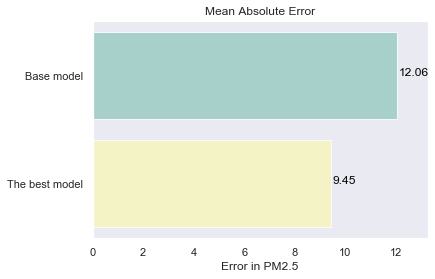

In [130]:
# show MAE for the best XGBoost and base model 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# set size and style
#fig.set_size_inches(10, 5)

sns.set_style('darkgrid')

# store values and labels in lists
X_plot = [base_mae, best_mae]
labels = ['Base model', 'The best model']

gap_show_value = 1.2

# plot percentages using bar plot
ax = sns.barplot(x=X_plot, y=labels, alpha=0.8, palette='Set3')
ax.set(xlim = (min(0, np.min(X_plot)), np.max(X_plot)+gap_show_value))

# display values of bars
for index,value in enumerate(X_plot):
    if value >=0:
        ax.text(value+0.05, index, str(round(value,2)), color='black')
    else:
        ax.text(value-gap_show_value/2, index, str(round(value,2)), color='black')

ax.set_xlabel('Error in PM2.5')
plt.title('Mean Absolute Error')
plt.show()
#ax.figure.savefig('images/MAE.png', bbox_inches="tight")

## Exploration of feature importance

## Shapley values for all the data

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


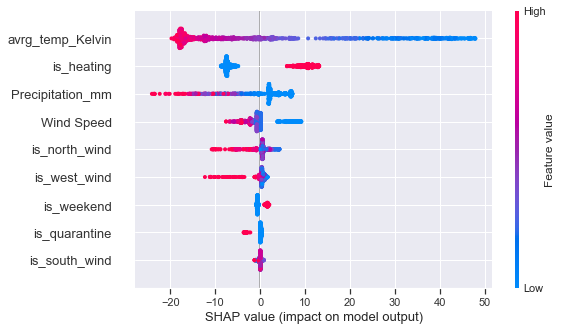

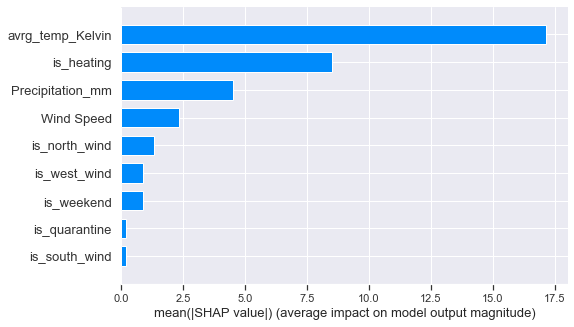

In [131]:
import shap
#to_explain = X[X['is_quarantine']==1]
to_explain = X
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(to_explain)

# summarize the effects of all the features
shap.summary_plot(shap_values, to_explain)

shap.summary_plot(shap_values, to_explain, plot_type="bar",  alpha=0.5)

## From the plots we see the SHAP values show that air temperature, heating season, rain and wind speed are most important for predicting PM2.5 using the model

### Plot the above feature importance graph with color coding for positive or negative correlation with the PM2.5 variable

In [132]:
# credits to ChrisKuoColumbiaU on github
def ABS_SHAP(df_shap,df, name):
    '''
        Plots SHAP values and colors them according to linear correlation with
        the 'name' feature in the 'df' dataframe. The shap values are stored in 'df_shap' dataframe
        and have values for each feature that is present in 'df'
    '''
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','green')
    
    # Plot it
    fig, ax = plt.subplots()

    # set size and style
    fig.set_size_inches(10, 7)
    shap_abs = np.abs(shap_v)
    df_shap =pd.DataFrame(shap_abs.mean()).reset_index()
    df_shap.columns = ['Variable','SHAP_abs']
    df_corr_shap = df_shap.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    df_corr_shap = df_corr_shap.sort_values(by='SHAP_abs',ascending = False)
    colorlist = df_corr_shap['Sign']
    
    ax = sns.barplot(y='Variable',x='SHAP_abs', alpha=0.8, data=df_corr_shap, palette=colorlist)
    #ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Correlation)")
    ax.set_title('Impact of the feature on prediction along with correlation')
    #ax.figure.savefig('images/' + name, bbox_inches="tight")

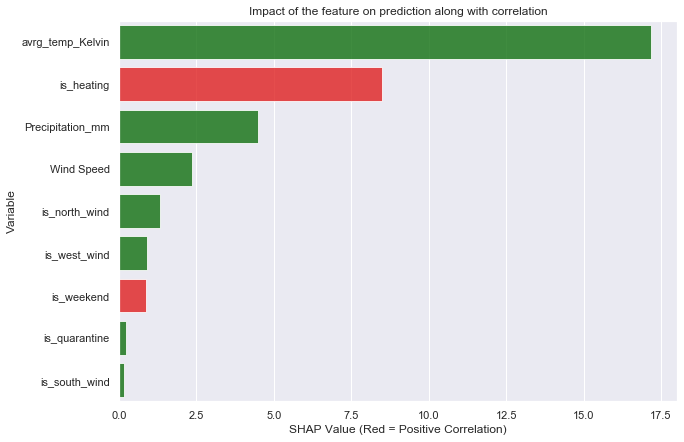

In [133]:
ABS_SHAP(shap_values,to_explain, 'shap_with_corr_all.png') 

#### Same SHAP values but now with correlation. Heating season and weekend have a positive correlation with PM2.5, while oher features have a negative correlation

## Impact on MAE when dropping a feature

In [134]:
# create a dataframe with feature importances based on error increase when a feature is dropped using whole data
importances = dropcol_importances(best_model, return_model_mae, X, y)

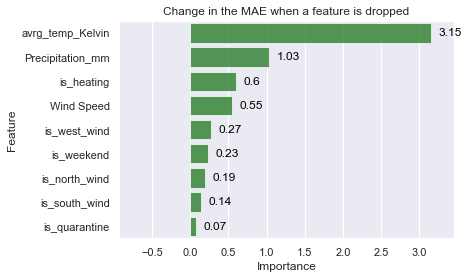

In [135]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# set size and style
#fig.set_size_inches(12.5, 7)

sns.set_style('dark')
ax = sns.barplot(y=importances.index, x=importances.Importance, palette=['green' if x > 0 else 'red' for x in importances.Importance],
                 alpha=0.7)
# show values
for index,value in enumerate(importances.Importance):
    if value >= 0:
        ax.text(value + 0.1, index, str(round(value,2)), color='black', va='center')
    else:
        ax.text(value - 0.6, index, str(round(value,2)), color='black', va='center')

# increase X axis to fit values of the bars
ax.set(xlim=(importances.Importance.min()-1,importances.Importance.max()+0.3))
    
plt.title('Change in the MAE when a feature is dropped')
plt.show()
#ax.figure.savefig('images/Feature_drop1.png', bbox_inches="tight")

#### Temperature, rain, wind and heating are still the most important features in the model when droppping features one by one

## Conclusion: Factors like air temperature, heating season, precipitation, and wind speed would be the most important in predicting PM2.5 values, and they are most likely affecting air pollution. 

# 2.2 Determining impact of the heating season on PM2.5 level

### Let's visualize PM2.5 data over time considering heating season

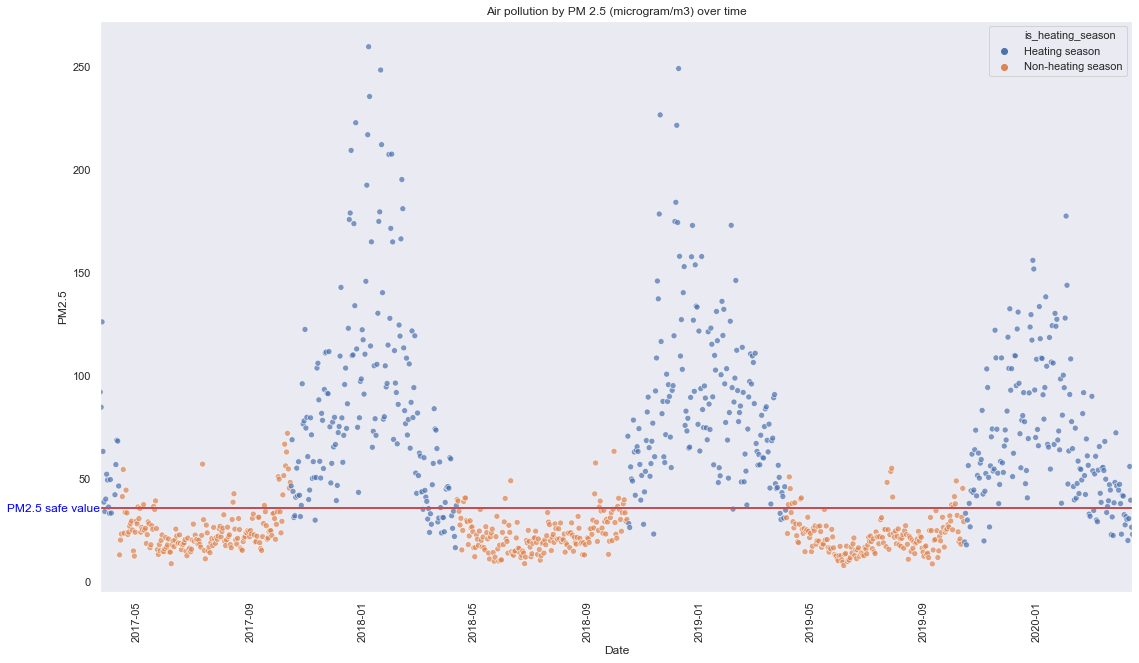

In [136]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

PM25_safe_value = 35.5
fig, ax = plt.subplots()
sns.set_style('darkgrid')
fig.set_size_inches(18.5, 10.5)
ax = sns.scatterplot(x='Date', y='PM2.5', data=dataAir, alpha=0.7, hue='is_heating_season')
ax.set(xlim = (dataAir['Date'].min(), dataAir['Date'].max()))
ax.hlines(y=PM25_safe_value, xmin= dataAir['Date'].min(), xmax=dataAir['Date'].max(), linewidth=2, color='r')
ax.text(dataAir['Date'].min(), PM25_safe_value, 'PM2.5 safe value', color='blue', va='center', ha='right')
plt.xticks(rotation=90)
plt.title('Air pollution by PM 2.5 (microgram/m3) over time')
plt.show()
#ax.figure.savefig('images/Heating_season_vs_pm25.png',bbox_inches="tight")

#### We see that during the heating season PM2.5 values are almost all above the safe value, while they are almost all OK outside of heating seasons. Moreover, we can spot a seasonal trend with increases of PM2.5 during the winters

### Plot the merged date of air temperature and air pollution

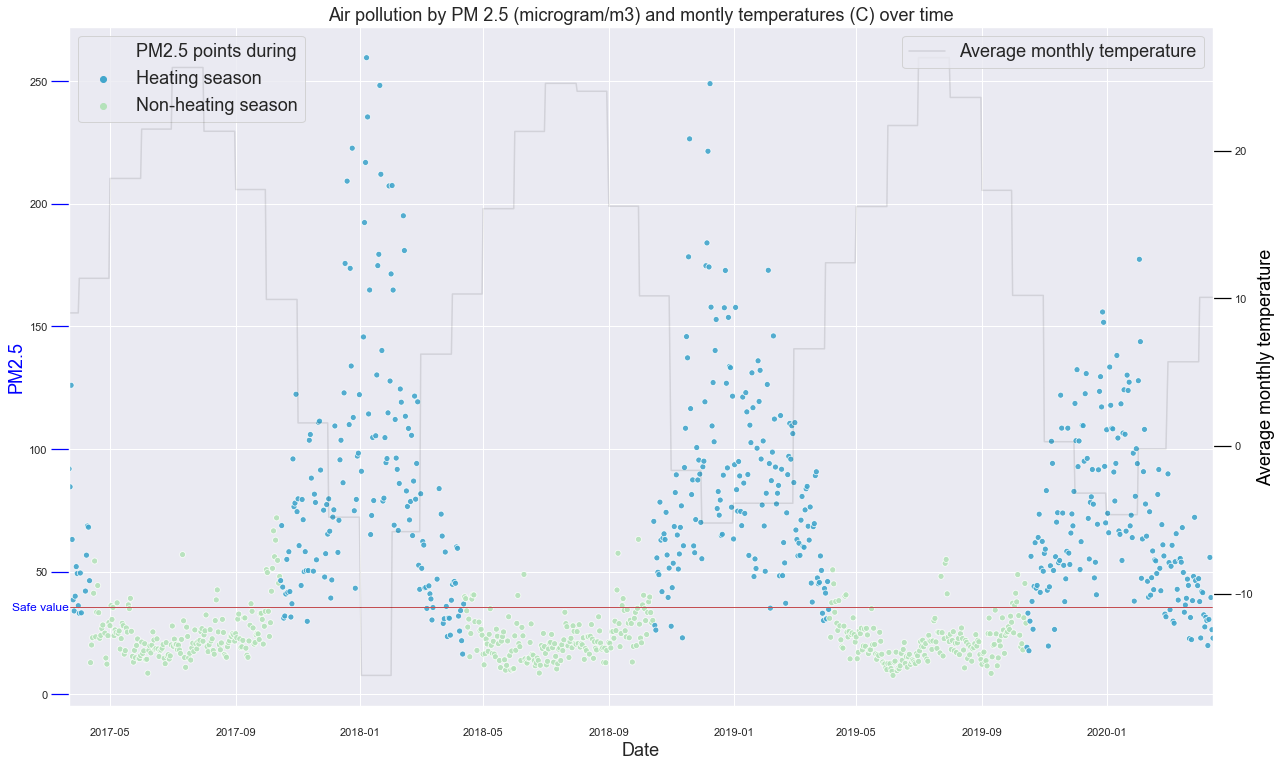

In [137]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# add month and year columns
dataMergedTemp['Month'] = dataMergedTemp['Date'].dt.month
dataMergedTemp['Year'] = dataMergedTemp['Date'].dt.year

# compute montly averages
monthlyAverages = dataMergedTemp.groupby(['Year', 'Month']).agg({'Temperature_C':'mean'}).copy()
monthlyAverages.rename(columns={'Temperature_C':'Average monthly temperature'}, inplace=True)

# add back the averages 
dataMergedTemp1 = pd.merge(dataMergedTemp, monthlyAverages, how='left', on=['Year', 'Month']).copy()

fig, ax = plt.subplots()

# set size and style
fig.set_size_inches(20.5, 12.5)
sns.set_style('dark')
#increasing fonts
#sns.set(font_scale = 2)

# rename is_heating_season column to have a better legend on the plot
heating_feature_name = "PM2.5 points during"
dataMergedTemp1.rename(columns={"is_heating_season": heating_feature_name}, inplace = True)

# plot air qulaity
fontsize = 18
color='blue'
ax = sns.scatterplot(x='Date', y='PM2.5',data = dataMergedTemp1,  alpha=0.9, hue=heating_feature_name, palette='GnBu_r')
ax.set(xlim = (dataMergedTemp1['Date'].min(), dataMergedTemp1['Date'].max()))
ax.hlines(y=PM25_safe_value, xmin=dataMergedTemp1['Date'].min(), xmax=dataMergedTemp1['Date'].max(), linewidth=1, color='r')
ax.text(dataMergedTemp1['Date'].min(), PM25_safe_value, 'Safe value', color='blue', va='center', ha='right')
ax.tick_params(axis='y', color=color, size=fontsize)
ax.tick_params(axis='x', size=fontsize)
ax.set_ylabel('PM2.5', color=color, fontsize=fontsize)
ax.set_xlabel('Date', size=fontsize)
ax.legend(loc='upper left', fontsize=fontsize)

# create a second y axis on the same X axis
ax2 = ax.twinx()

# plot air temperature
color='black'
ax2 = sns.lineplot(x='Date', y='Average monthly temperature',data = dataMergedTemp1,  alpha=0.1, color=color)
ax2.tick_params(axis='y', color=color, size=fontsize)
ax2.set_ylabel('Average monthly temperature', color=color, fontsize=fontsize)
ax2.legend(['Average monthly temperature'], loc='upper right', fontsize=fontsize)
#ax.set_xticklabels(size = fontsize)


rc={'xtick.labelsize': fontsize, 'font.size': fontsize}
sns.set(rc=rc)

# set final parameters and draw
#plt.rcParams.update({'font.size': fontsize})
plt.xticks(rotation=90)
ax2.axes.set_title('Air pollution by PM 2.5 (microgram/m3) and montly temperatures (C) over time', fontsize=fontsize)
plt.show()

#ax2.figure.savefig('images/Temp_vs_pm25.png', bbox_inches="tight")

# back to default seaborn parameters
#sns.set()


#### The PM2.5 values show reverse relationship with air temperatures

### Find out percentage of days with normal air

Total number of days in 2019: 365
Percentage of days with normal air: 52.0
Percentage of days with unhealthy air: 48.0


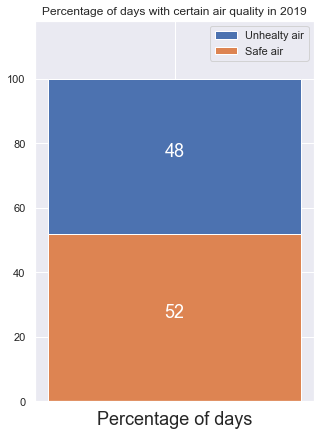

In [138]:
import matplotlib.pyplot as plt

numb_days_2019 = dataAir[dataAir['Date'].dt.year == 2019].shape[0]
print('Total number of days in 2019:', numb_days_2019)
normal_air = round(100*dataAir[(dataAir['PM2.5']<=PM25_safe_value) & (dataAir['Date'].dt.year == 2019)].shape[0]/numb_days_2019,0)
unhealthy_air = round(100*dataAir[(dataAir['PM2.5']>PM25_safe_value) & (dataAir['Date'].dt.year == 2019)].shape[0]/numb_days_2019,0)
print('Percentage of days with normal air:', normal_air)
print('Percentage of days with unhealthy air:', unhealthy_air)

# store values and labels in lists
percentages = [normal_air, unhealthy_air]
labels_percentages = ['Normal air', 'Unhealty air']

fig, ax = plt.subplots()
fig.set_size_inches(5, 7)

ax.bar('Percentage of days', unhealthy_air, bottom=normal_air, label='Unhealty air')
ax.bar('Percentage of days', normal_air,  label='Safe air')

ax.set(ylim = (0,118))
ax.legend()

# add text to show values 
ax.text(0,normal_air/2,str(int(normal_air)),ha='center', color='white')
ax.text(0,normal_air + unhealthy_air/2,str(int(unhealthy_air)),ha='center', color='white')

# plot percentages using pie chart
#plt.pie(percentages, labels=labels_percentages, autopct='%1.0f%%')
    
plt.title('Percentage of days with certain air quality in 2019')
plt.show()
#ax.figure.savefig('images/overall_percentage_air.png',bbox_inches="tight")

#### Almost half of the days in 2019 had unsafe air

### See what percentage of days have safe air during the heating season and outside of it

Percentage of days with normal air outside heating seasons: 90.0
Percentage of days with normal air during heating seasons: 11.0
Percentage of days with normal air regardless of heating seasons: 51.0


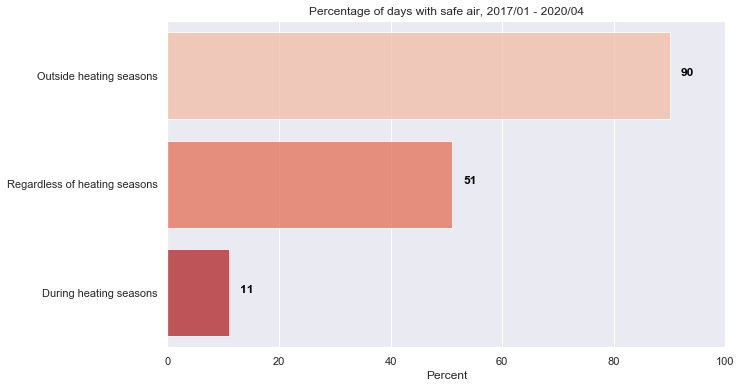

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# get the needed number of days
numb_Safe_Air_Days_No_Heating = dataAir[(dataAir['PM2.5']<=PM25_safe_value) & (dataAir['is_heating'] == 0)].shape[0]
numb_Safe_Air_Days_Heating = dataAir[(dataAir['PM2.5']<=PM25_safe_value) & (dataAir['is_heating'] == 1)].shape[0]
numb_No_Heating_Days = dataAir[dataAir['is_heating'] == 0].shape[0]
numb_Heating_Days = dataAir[dataAir['is_heating'] == 1].shape[0]

total_days = dataAir.shape[0]
normal_air_days = dataAir['PM2.5'][dataAir['PM2.5']<=PM25_safe_value].count()

# calcualate percentages
no_heating_percent = round(100*(numb_Safe_Air_Days_No_Heating/numb_No_Heating_Days),0)
heating_percent = round(100*(numb_Safe_Air_Days_Heating/numb_Heating_Days),0)
normal_air_percent = round(100*normal_air_days/total_days,0)

print('Percentage of days with normal air outside heating seasons:', no_heating_percent)
print('Percentage of days with normal air during heating seasons:', heating_percent)
print('Percentage of days with normal air regardless of heating seasons:', normal_air_percent)

fig, ax = plt.subplots()

# set size and style
fig.set_size_inches(10, 6)

sns.set_style('darkgrid')

# store values and labels in lists
X_plot = [no_heating_percent, normal_air_percent, heating_percent]
labels = ['Outside heating seasons', 'Regardless of heating seasons', 'During heating seasons']

# plot percentages using bar plot
ax = sns.barplot(x=X_plot, y=labels, alpha=0.8, palette='Reds')
ax.set(xlim = (0,100))

# display values of bars
for index,value in enumerate(X_plot):
    ax.text(value+2, index, str(int(value)), color='black', fontweight='bold')

ax.set_xlabel('Percent')    
plt.title('Percentage of days with safe air, 2017/01 - 2020/04')
plt.show()
#ax.figure.savefig('images/percentage_days_normal_air.png', bbox_inches="tight")

#### Almost all days outside the heating season have safe air, while the opposite is true for the heating season

### Compute averages during and outside the heating season

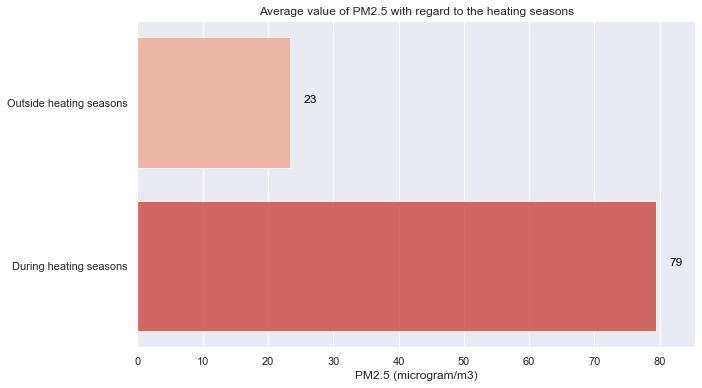

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

average_non_heating = dataAir['PM2.5'][dataAir['is_heating']==0].mean()
average_heating = dataAir['PM2.5'][dataAir['is_heating']==1].mean()

fig, ax = plt.subplots()
# set size and style
fig.set_size_inches(10, 6)

sns.set_style('darkgrid')

# store values and labels in lists
X_plot = [average_non_heating, average_heating]
labels = ['Outside heating seasons', 'During heating seasons']

# plot percentages using bar plot
ax = sns.barplot(x=X_plot, y=labels, alpha=0.8, palette='Reds')

gap=2
# display values of bars
for index,value in enumerate(X_plot):
    ax.text(value+gap, index, str(int(value)), color='black')

ax.set(xlim = (0,max(X_plot)+3*gap))
ax.set_xlabel('PM2.5 (microgram/m3)')    
plt.title('Average value of PM2.5 with regard to the heating seasons')
plt.show()
#ax.figure.savefig('images/average_pm25_heating.png', bbox_inches="tight")

#### The average value of PM2.5 is more than 50 units higher during the heating season

## Conclusion: During the heating seasons air quality deteriorates significantly and becomes unsafe while the air pollution levels during non-heating seasons on average are safe and 50 units lower.

# 2.3 Determining impact of the quarantine on PM2.5 level

## Impact of quarantine on the whole dataset

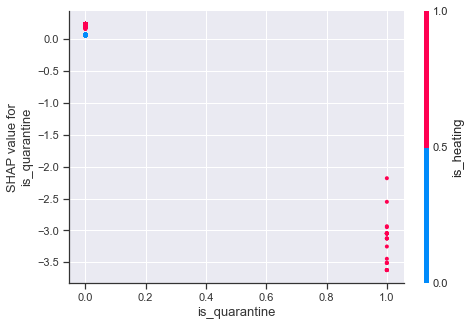

In [142]:
shap.dependence_plot('is_quarantine', shap_values, to_explain)

#### Quarantine has mostly zero effect on predicting PM2.5 outside of it, but there during the quarantine we clearly see it decreasing PM2.5

In [143]:
shap_df = pd.DataFrame(shap_values, columns=to_explain.columns)
average_shap_quarantine_all = shap_df['is_quarantine'].mean()
print(average_shap_quarantine_all)

0.03435351327061653


## Impact by shapley values during quarantine

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


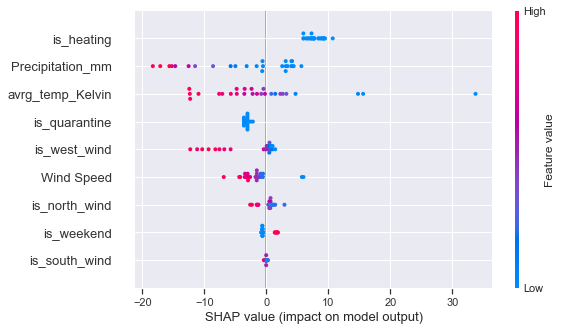

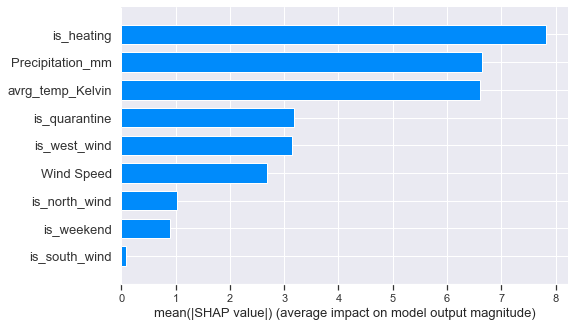

In [144]:
import shap
to_explain = X[X['is_quarantine']==1]
#to_explain = X
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(to_explain)

# summarize the effects of all the features
shap.summary_plot(shap_values, to_explain)

shap.summary_plot(shap_values, to_explain, plot_type="bar",  alpha=0.5)

#### During quarantine order of importance for some variables changes, and we see quarantine variable being much more important that ouside the lockdown

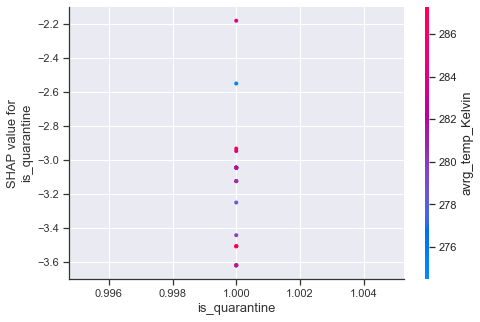

In [145]:
shap.dependence_plot('is_quarantine', shap_values, to_explain)

#### During quarantine is_quarantine varaible has an impact on PM2.5 ranging from -2.2 to -3.6, which tells us that the variable has importance during quarantine, but then due to having 0 impact outside of the period, the average SHAP is small, which is a distorted view

In [160]:
shap_df = pd.DataFrame(shap_values, columns=to_explain.columns)
average_shap_quarantine_only = shap_df['is_quarantine'].mean()
print(average_shap_quarantine_only)

-3.181896448135376


## Shapley values outside of quarantine

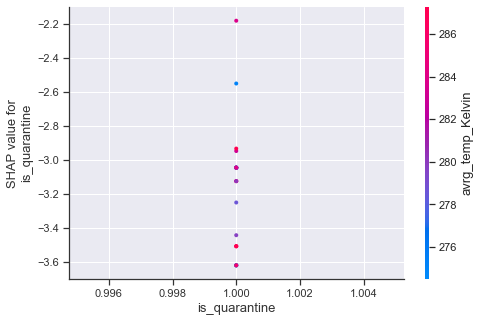

In [148]:
shap.dependence_plot('is_quarantine', shap_values, to_explain)

#### Outside of quarantine the quarantine variable predictably has a low impact on forecast

In [162]:
# let's calculate average SHAP values outside quarantine
to_explain = X[X['is_quarantine']==0]
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(to_explain)

shap_df = pd.DataFrame(shap_values, columns=to_explain.columns)
average_shap_quarantine_outside = shap_df['is_quarantine'].mean()
print(average_shap_quarantine_outside)

0.12726736068725586


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## Plot average shapley numbers (not absolute)

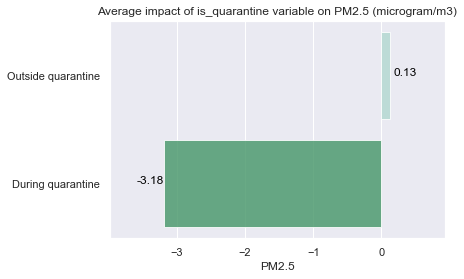

In [163]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('darkgrid')

fig, ax = plt.subplots()

# set size and style
#fig.set_size_inches(11.5, 5)

# store values and labels in lists
shap_quarantine = [average_shap_quarantine_outside, average_shap_quarantine_only]
labels = ['Outside quarantine', 'During quarantine']

gap_show_value = 0.8

# plot percentages using bar plot
ax = sns.barplot(x=shap_quarantine, y=labels, alpha=0.8, palette='BuGn')
ax.set(xlim = (np.min(shap_quarantine)-gap_show_value, np.max(shap_quarantine)+gap_show_value))

# display values of bars
for index,value in enumerate(shap_quarantine):
    if value >=0:
        ax.text(value+0.05, index, str(round(value,2)), color='black')
    else:
        ax.text(value-gap_show_value/2, index, str(round(value,2)), color='black')

ax.set_xlabel('PM2.5')
plt.title('Average impact of is_quarantine variable on PM2.5 (microgram/m3)')
plt.show()
#ax.figure.savefig('images/quarantine_impact.png', bbox_inches="tight")

#### We see that indeed average impact of quarantine, when considered separately in and out of lockdown, is significant and negative on PM2.5, unlike the average absolute impact (without sign) on the whole dataset which becomes biased due to almsot 900 points having zero impact from quarantine (outside of it), and only 26 points (inside quarantine) having some impact

## Experiment to determine if during quarantine we observed less pollution
### For each day during quarantine compare PM2.5 value with similar days ouside the quarantine. 

### Create a function diff_btw_similar_events that for a given feature will compute differences between all events in dataframe1 and events in dataframe2 that are similar to events in dataframe1 as specified by given criteria

In [151]:
def diff_btw_similar_events(dataframe1, dataframe2, diff_feature, index_features, abs_diff, abs_diff_thresholds, percent_diff, percent_diff_thresholds, no_diff, plot=False):
    '''    
    Description:
        The diff_btw_similar_events function will compute for one required feature 
        the differences between all events in dataframe1 and events in dataframe2 
        that are similar to events in dataframe1 as specified by given criteria.
        Also draws the differences using seaborn if plot = True.
    Input parameters:
        dataframe1 - the main dataframe for which we search for similar rows in dataframe2;
        dataframe2 - the dataframe where we search for similar rows to rows in dataframe1;
        diff_feature - string, the name of the feature for which we compute differences;
        index_features - list of strings, the names of the distinguishing features so that we don't return exactly the same rows as similar in case we run function on one dataframe;
        abs_diff - list of strings, names of the featuxres that must differ from each other by less than some absolute values for rows to be similar;
        abs_diff_thresholds - list of numbers, stores difference values for features in abs_diff;
        percent_diff - list of strings, names of the features that must differ from each other by less than some percent values relative to dataframe for rows to be similar;
        percent_diff_thresholds - list of numbers (from 0 to 100), stores percent difference values for features in abs_diff. Note that if one of the values is zero, the other would must be zero as well to avoid troubles with percentages;
        no_diff - list of string, names of the features that must have exactly the same value for rows to be considered similar
        plot - (default = False) boolean, whether to plot the difference using seaborn barplot
    Returns:
        The dataframe1 with 2 new columns 
            1. dataframe1['similar_value_' + diff_feature] = for each row in dataframe1 a 
                list with values of a required feature from dataframe2 for rows that are 
                similar to the row from dataframe1  as defined by input critea
            2. dataframe1['diffrerence_' + diff_feature] = dataframe1[diff_feature] - dataframe1['similar_value_' + diff_feature]
        
    '''
    import numpy as np
    import copy
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # create a copy of dataframe1 to store new columns without altering the initial input
    dataframe1_copy = copy.deepcopy(dataframe1)
    # a list of list that stores a list of similar values from dataframe2 for each row in dataframe1
    similar_days = []
    for index_1, row_1 in dataframe1_copy.iterrows():
        similar_days.append([])
        for index_2, row_2 in dataframe2.iterrows():
            # in case dataframe1 == dataframe2 we don't want to return the same rows as similar
            # similar_indexes - count how many of the index features are the same and if all are - skip
            similar_indexes = 0
            for feature in index_features:
                if row_1[feature] == row_2[feature]:
                    similar_indexes += 1
            if similar_indexes == len(index_features):
                continue
            
            # go through features and apply criteria - store in criteria_met array True if criteria is satisfied, False otherwise
            criteria_met = []
            # no difference at all features
            for cat_feature in no_diff:
                if (row_2[cat_feature] == row_1[cat_feature]):
                    criteria_met.append(True)
                else:
                    criteria_met.append(False)
            # percent difference features
            for feature, threshold in zip(percent_diff, percent_diff_thresholds):
                # case when both not zero
                if (row_1[feature] != 0) and (row_2[feature]!=0):
                    if ( 100*abs(row_1[feature] - row_2[feature])/row_1[feature] ) < threshold:
                        criteria_met.append(True)
                    else:
                        criteria_met.append(False)
                # else if one of them is zero, the second must be zero as well
                elif (row_1[feature] == row_2[feature]) :
                    criteria_met.append(True)
                # esle False 
                else:
                    criteria_met.append(False)
                            
            # absolute difference features
            for feature, threshold in zip(abs_diff, abs_diff_thresholds):
                if (abs(row_1[feature] - row_2[feature]) < threshold):
                    criteria_met.append(True)
                else:
                    criteria_met.append(False)
            
            # check if all criteria were met - if yes, append PM2.5 value for that quarantie day
            if np.all(criteria_met):
                similar_days[index_1].append(row_2[diff_feature])

    # print how many similar days were found for each row in dataframe1
    #print('The count of rows in dataframe2 that were determined to be similar for each row in dataframe1:')
    #for x in similar_days:
        #print(len(x))
    
    # compute standard deviation
    std_similar_days = np.array([np.std(x) for x in similar_days])
    averages_similar_days = np.array([np.mean(x) for x in similar_days])
    
    # when compution average std exclude NaN values and points that have only one similar row 
    # as they have zero std and will drive the average down
    # std_to_keep - mask that has values that satisfy conditions
    std_to_keep = np.where((std_similar_days != 0) &(~np.isnan(std_similar_days)), True, False)
    average_std = np.mean(std_similar_days[std_to_keep])
    print('Average standard deviation:', average_std)
    
    
    # drop values in averages that have std > average std by turning them to nan
    threshold = average_std
    std_similar_days = np.array([std if (std <= threshold ) else float("nan") for std in std_similar_days])
    averages = [avg if (std <= threshold ) else float("nan") for avg, std in zip(averages_similar_days, std_similar_days)]
    
    # when compution average std exclude NaN values and points that have only one similar row 
    # as they have zero std and will drive the average down
    # std_to_keep - mask that has values that satisfy conditions
    std_to_keep = np.where((std_similar_days != 0) &(~np.isnan(std_similar_days)), True, False)
    new_average_std = np.mean(std_similar_days[std_to_keep])
    print('New average standard deviation after dropping too large values of std:', new_average_std)
    
    
    dataframe1_copy['similar_value_' + diff_feature] = averages
    dataframe1_copy['difference_' + diff_feature] = dataframe1_copy.apply(lambda row: (row[diff_feature] - row['similar_value_' + diff_feature]),axis=1)
    
    # plotting the differences
    if plot:
        fig, ax = plt.subplots()
        # set size and style
        fig.set_size_inches(14.5, 7.5)
        
        # average difference between values
        mean_diff = dataframe1_copy['difference_' + diff_feature].mean()

        sns.set_style('darkgrid')
        ax = sns.barplot(x=dataframe1_copy.index, y=dataframe1_copy['difference_' + diff_feature], palette=['green' if value < 0 else 'red' for value in dataframe1_copy['difference_' + diff_feature]],
                         alpha=0.7)   
        ax.hlines(y=mean_diff, xmin= dataframe1_copy.index.min(), xmax=dataframe1_copy.index.max(), linewidth=1, color='r')
        ax.text(dataframe1_copy.index.min(), mean_diff, 'Average difference', color='blue', va='bottom')

        plt.title('Differences in ' + diff_feature +' for similar rows')
        #ax.figure.savefig('images/difference_average')
        plt.show()
    
    return dataframe1_copy


## Define similar days as those that 
1. differ by less than 1 degree in temperature 
2. differ by less then 5% thresholds in terms of wind speed, precipitation
3. if there was no precipitation or wind in one of the days, then the other should also have no precipitation or wind
4. have the same selected categorical values is_heating

In [152]:
# create dataframaes with data ouside and during quarantine
# and see how similar in terms of the weather and heating season days are different in terms of PM2.5

import numpy as np
quarantine_days = copy.deepcopy(dataMerged[dataMerged['is_quarantine'] == 1]).reset_index()
not_quarantine_days = copy.deepcopy(dataMerged[dataMerged['is_quarantine'] == 0]).reset_index()

# criteria for similar days

# absolute differences for columns in abs_diff  must be within values in abs_diff_thresholds
abs_diff = ['avrg_temp_Kelvin']
temp_criteria = 1
abs_diff_thresholds = [temp_criteria]

# percent differences for columns in percent_diff  must be within values in percent_diff_thresholds
# and if one value is 0, the other must be 0 as well for values in 2 groups
percent_diff = ['Wind Speed', 'Precipitation_mm']
threshold_wind = 5
threshold_precip = 5
percent_diff_thresholds = [threshold_wind, threshold_precip]

# values for these columns must be exactly the same for 2 groups
no_diff = ['is_heating']

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


Average standard deviation: 14.997910277258093
New average standard deviation after dropping too large values of std: 7.073871247571172


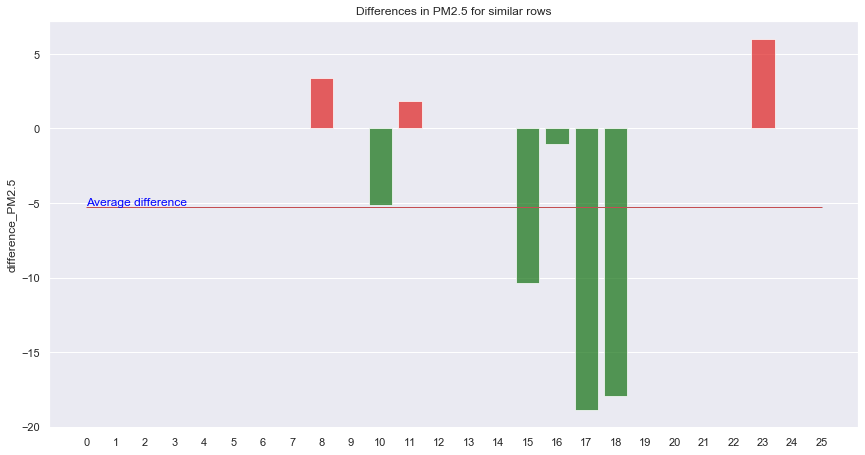

-5.27


In [153]:
# run analysis on difference in PM2.5 btw quarantine and non-quarantinedays when 
# controlled for weather and heating and plot the differences
quarantine_days_new = diff_btw_similar_events(quarantine_days, not_quarantine_days, 'PM2.5', ['Date'], abs_diff, abs_diff_thresholds, percent_diff, percent_diff_thresholds, no_diff, True)
print(round(quarantine_days_new['difference_PM2.5'].mean(),2))

#### We see a negative impact on values of PM2.5 from quarantine

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


Average standard deviation: 11.16015828286257
New average standard deviation after dropping too large values of std: 6.084023073139864


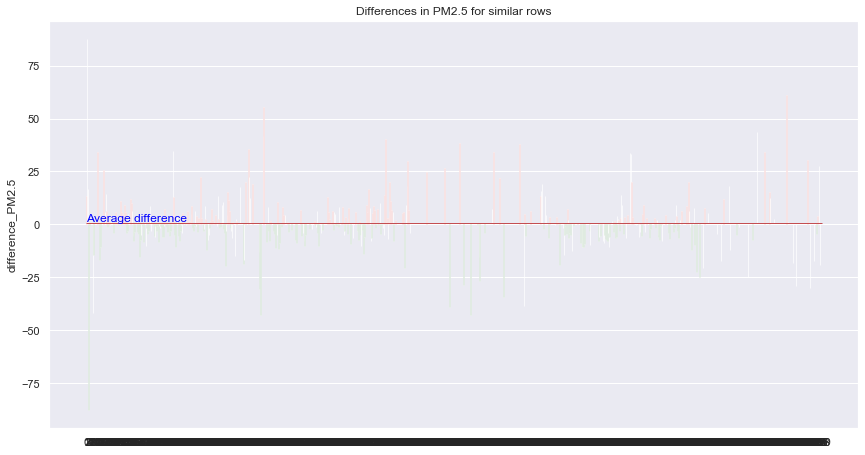

0.53


In [154]:
# run analysis on PM2.5 differences btw similar in terms of the weather and heating season non-quarantine days
# plot the differences
average_diffs = diff_btw_similar_events(not_quarantine_days, not_quarantine_days, 'PM2.5', ['Date'], abs_diff, abs_diff_thresholds, percent_diff, percent_diff_thresholds, no_diff, True)
print(round(average_diffs['difference_PM2.5'].mean(),2))

#### We see both positive and negative differences between PM2.5 when compaing values that are both outside quarantime, and a small average difference, which means the differences are probably random or can be explained by some other factors we are not considering

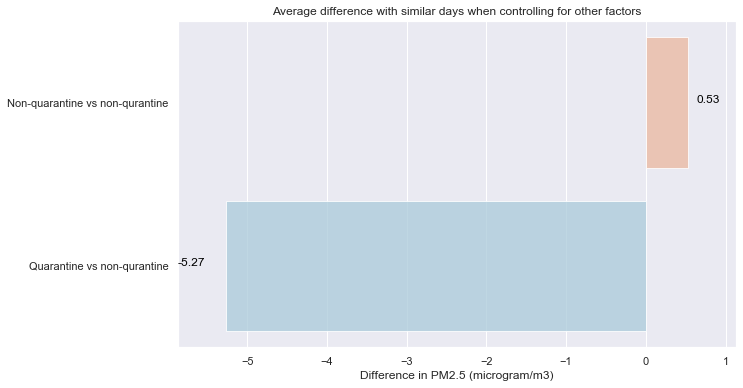

In [155]:
# plot the values of average diifference btw similar non-quarantine days 
# and for similar days dirung quarantine vs non-quarantine

import numpy as np
import seaborn as sns

fig, ax = plt.subplots()

# set size and style
fig.set_size_inches(10, 6)

sns.set_style('darkgrid')

# store values and labels in lists
X_plot = [average_diffs['difference_PM2.5'].mean(), quarantine_days_new['difference_PM2.5'].mean()]
labels = ['Non-quarantine vs non-qurantine', 'Quarantine vs non-qurantine']

gap_show_value = 0.6

# plot percentages using bar plot
ax = sns.barplot(x=X_plot, y=labels, alpha=0.8, palette='RdBu')
ax.set(xlim = (np.min(X_plot)-gap_show_value, np.max(X_plot)+gap_show_value))

# display values of bars
for index,value in enumerate(X_plot):
    if value >=0:
        ax.text(value+0.1, index, str(round(value,2)), color='black')
    else:
        ax.text(value-gap_show_value, index, str(round(value,2)), color='black')

ax.set_xlabel('Difference in PM2.5 (microgram/m3)')
plt.title('Average difference with similar days when controlling for other factors')
plt.show()


#ax.figure.savefig('images/Differences_in_PM25_quarantine.png', bbox_inches="tight")

### Both the Shapley values and comparing similar days (in terms of the temperature, wind speed, precipation, heating season) during and outside qurantine show that quarantine indeed had an impact in lowering PM2.5, but the average impact is -3 and -5 microgramm/m3 for the two methods respectively, which is not very significant compared to the effects of air temperature, heating season,  wind speed or precipation - each of them contributes to the PM2.5 values much more.

## Analyzing impact of the heating seasons while controlling for other factors

In [156]:
# create dataframes of days within and outside heating seasons
heating_days = copy.deepcopy(dataMerged[dataMerged['is_heating'] == 1]).reset_index()
not_heating_days = copy.deepcopy(dataMerged[dataMerged['is_heating'] == 0]).reset_index()

# values for these columns must be exactly the same for 2 groups
no_diff = ['is_quarantine']

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


Average standard deviation: 8.86128495917469
New average standard deviation after dropping too large values of std: 5.888742029060362


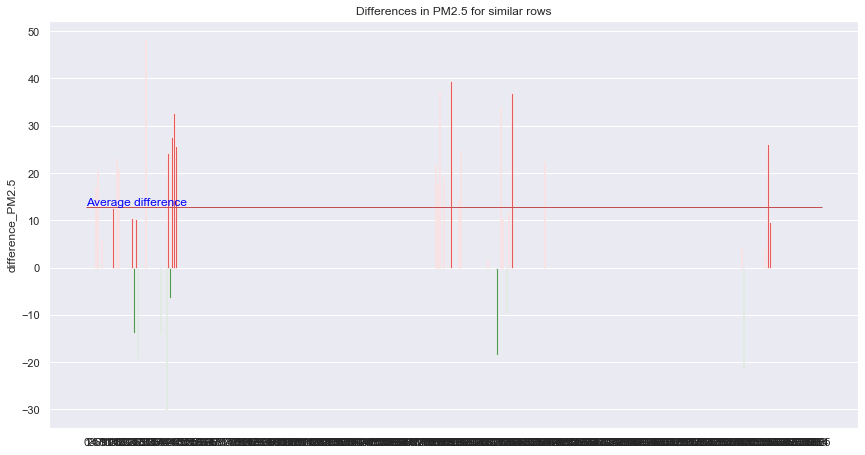

12.7


In [157]:
# run analysis to determine difference in PM2.5 btw similar in terms of the weather and quarantine days for values
# outside vs inside heating days
heating_days_new = diff_btw_similar_events(heating_days, not_heating_days, 'PM2.5', ['Date'], abs_diff, abs_diff_thresholds, percent_diff, percent_diff_thresholds, no_diff, True)
print(round(heating_days_new['difference_PM2.5'].mean(),2))

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


Average standard deviation: 20.35636046119471
New average standard deviation after dropping too large values of std: 12.402762934481839


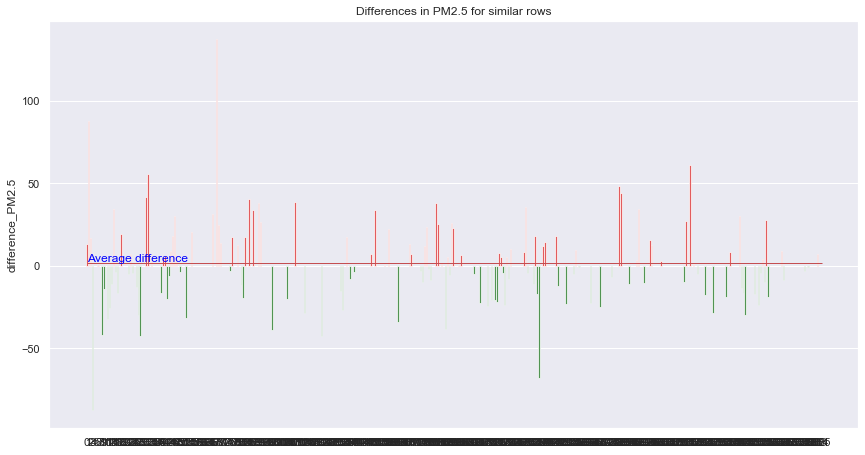

1.45


In [158]:
# run analysis to determine difference in PM2.5 btw similar in terms of the weather and quarantine days for values
# inside heating days
heating_days_2 = diff_btw_similar_events(heating_days, heating_days, 'PM2.5', ['Date'], abs_diff, abs_diff_thresholds, percent_diff, percent_diff_thresholds, no_diff, True)
print(round(heating_days_2['difference_PM2.5'].mean(),2))

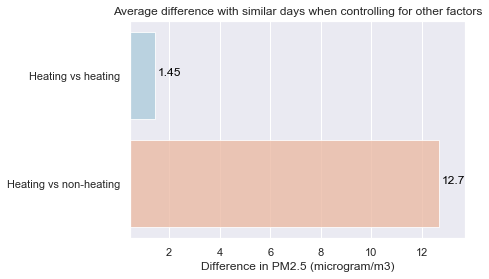

In [159]:
# plot the differences in PM2.5 values for similar days for heating vs heating and heating vs non-heating season
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#set size and style
#fig.set_size_inches(6, 4)

sns.set_style('darkgrid')

# store values and labels in lists
X_plot = [heating_days_2['difference_PM2.5'].mean(), heating_days_new['difference_PM2.5'].mean()]
labels = ['Heating vs heating','Heating vs non-heating']

gap_show_value = 1

# plot percentages using bar plot
ax = sns.barplot(x=X_plot, y=labels, alpha=0.8, palette='RdBu_r')
ax.set(xlim = (np.min(X_plot)-gap_show_value, np.max(X_plot)+gap_show_value))

# display values of bars
for index,value in enumerate(X_plot):
    if value >=0:
        ax.text(value+0.1, index, str(round(value,2)), color='black')
    else:
        ax.text(value-gap_show_value, index, str(round(value,2)), color='black')

ax.set_xlabel('Difference in PM2.5 (microgram/m3)')
plt.title('Average difference with similar days when controlling for other factors')
plt.show()


#ax.figure.savefig('images/Differences_in_PM25_heating.png', bbox_inches="tight")

#### The above graph shows that heating season has an impact on PM2.5, and the value is in line with what SHAP value has showed

## Conclusion: During the lockdown PM2.5 values have decreased by approximately 5 microgram/m3 when controlling for other factors, which is noticeable, but would not be enough to drive pollution down to safe levels during the heating seasons as the average PM2.5 then is almost 80 units.

# 3. Conclusions
The above analysis shows that although there was a positive impact on air quality from a lockdown with almost no traffic, the heating seasons along with weather conditions like air temperature, wind, and precipitations, have much more impact on air pollution.